In [2]:
import re

In [436]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gp
import urllib
import json
from fiona.crs import from_epsg
import shapely

plt.style.use("ggplot")
%matplotlib inline

In [447]:
import matplotlib.cm as cm

In [3]:
data_1 = gp.GeoDataFrame.from_csv("NYPD_7_Major_Felony_Incidents.csv", parse_dates=["Occurrence Date"])

In [4]:
data_2 = gp.GeoDataFrame.from_csv("NYPD_Motor_Vehicle_Collisions.csv", parse_dates=["DATE"])

In [5]:
data_1.head()

,Identifier,Occurrence Date,Day of Week,Occurrence Month,Occurrence Day,Occurrence Year,Occurrence Hour,CompStat Month,CompStat Day,CompStat Year,Offense,Offense Classification,Sector,Precinct,Borough,Jurisdiction,XCoordinate,YCoordinate,Location 1
OBJECTID,,,,,,,,,,,,,,,,,,,
1.0,f070032d,1940-09-06 19:30:00,Friday,Sep,6.0,1940.0,19.0,9.0,7.0,2010.0,BURGLARY,FELONY,D,66.0,BROOKLYN,N.Y. POLICE DEPT,987478.0,166141.0,"(40.6227027620001, -73.9883732929999)"
2.0,c6245d4d,1968-12-14 00:20:00,Saturday,Dec,14.0,1968.0,0.0,12.0,14.0,2008.0,GRAND LARCENY,FELONY,G,28.0,MANHATTAN,N.Y. POLICE DEPT,996470.0,232106.0,"(40.8037530600001, -73.955861904)"
3.0,716dbc6f,1970-10-30 15:30:00,Friday,Oct,30.0,1970.0,15.0,10.0,31.0,2008.0,BURGLARY,FELONY,H,84.0,BROOKLYN,N.Y. POLICE DEPT,986508.0,190249.0,"(40.688874254, -73.9918594329999)"
4.0,638cd7b7,1972-07-18 23:00:00,Tuesday,Jul,18.0,1972.0,23.0,7.0,19.0,2012.0,GRAND LARCENY OF MOTOR VEHICLE,FELONY,F,73.0,BROOKLYN,N.Y. POLICE DEPT,1005876.0,182440.0,"(40.6674141890001, -73.9220463899999)"
5.0,6e410287,1987-05-21 00:01:00,Thursday,May,21.0,1987.0,0.0,5.0,28.0,2009.0,GRAND LARCENY,FELONY,K,75.0,BROOKLYN,N.Y. POLICE DEPT,1017958.0,182266.0,"(40.6668988440001, -73.878495425)"


In [6]:
data_2.head()

,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
DATE,,,,,,,,,,,,,,,,,,,,,
2015-08-25,19:00,NaN,NaN,40.732941,-73.920382,"(40.7329414, -73.9203819)",NaN,NaN,NaN,0,...,Unspecified,NaN,NaN,NaN,3284922,PASSENGER VEHICLE,TAXI,NaN,NaN,NaN
2012-07-27,22:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,Unspecified,NaN,NaN,NaN,2833714,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN
2014-05-17,0:45,NaN,NaN,NaN,NaN,NaN,PENNSYLVANIA AVENUE,RIVERDALE AVENUE,NaN,0,...,NaN,NaN,NaN,NaN,336679,NaN,NaN,NaN,NaN,NaN
2016-07-27,7:07,BROOKLYN,11233.0,NaN,NaN,NaN,REID AVENUE,MARION STREET,NaN,0,...,Unspecified,NaN,NaN,NaN,3502510,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN
2016-07-27,7:07,MANHATTAN,10065.0,NaN,NaN,NaN,1 AVENUE,EAST 65 STREET,NaN,0,...,Unspecified,NaN,NaN,NaN,3489259,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN


In [7]:
vehicledata = data_2.drop(["CONTRIBUTING FACTOR VEHICLE 1","CONTRIBUTING FACTOR VEHICLE 2","CONTRIBUTING FACTOR VEHICLE 3",
                           "CONTRIBUTING FACTOR VEHICLE 4","CONTRIBUTING FACTOR VEHICLE 5","UNIQUE KEY","VEHICLE TYPE CODE 1",
                          "VEHICLE TYPE CODE 2","VEHICLE TYPE CODE 3","VEHICLE TYPE CODE 4","VEHICLE TYPE CODE 5"],axis=1) 

In [8]:
crimedata = data_1[["Occurrence Date", "Offense Classification", "Precinct", "Borough", "Location 1"]]

In [9]:
vehicledata.head()

,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED
DATE,,,,,,,,,,,,,,,,,
2015-08-25,19:00,NaN,NaN,40.732941,-73.920382,"(40.7329414, -73.9203819)",NaN,NaN,NaN,0,0,0,0,0,0,0,0
2012-07-27,22:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
2014-05-17,0:45,NaN,NaN,NaN,NaN,NaN,PENNSYLVANIA AVENUE,RIVERDALE AVENUE,NaN,0,0,0,0,0,0,0,0
2016-07-27,7:07,BROOKLYN,11233.0,NaN,NaN,NaN,REID AVENUE,MARION STREET,NaN,0,0,0,0,0,0,0,0
2016-07-27,7:07,MANHATTAN,10065.0,NaN,NaN,NaN,1 AVENUE,EAST 65 STREET,NaN,0,0,0,0,0,0,0,0


In [10]:
crimedata = crimedata.reset_index(drop=True)

In [11]:
crimedata.head()

,Occurrence Date,Offense Classification,Precinct,Borough,Location 1
0,1940-09-06 19:30:00,FELONY,66.0,BROOKLYN,"(40.6227027620001, -73.9883732929999)"
1,1968-12-14 00:20:00,FELONY,28.0,MANHATTAN,"(40.8037530600001, -73.955861904)"
2,1970-10-30 15:30:00,FELONY,84.0,BROOKLYN,"(40.688874254, -73.9918594329999)"
3,1972-07-18 23:00:00,FELONY,73.0,BROOKLYN,"(40.6674141890001, -73.9220463899999)"
4,1987-05-21 00:01:00,FELONY,75.0,BROOKLYN,"(40.6668988440001, -73.878495425)"


In [12]:
vehicledata = vehicledata.dropna(subset=["LATITUDE"])

In [13]:
crimedata = crimedata.dropna()

In [42]:
def broke(data):
    lat = float(re.split("[\(\,\s\)]", data)[1])
    lon = float(re.split("[\(\,\s\)]", data)[3])
    return lat, lon

In [15]:
latlon = crimedata["Location 1"].apply(broke)

In [16]:
crimedata["latlon"] = latlon

In [17]:
crimedata["longitude"] = 0
crimedata["latitude"] = 0

In [18]:
crimedata["longitude"] = crimedata["latlon"].apply(lambda x: x[1])
crimedata["latitude"] = crimedata["latlon"].apply(lambda x: x[0])

In [19]:
crimedata.drop(["Location 1"], axis=1, inplace=True)

In [20]:
crimedata["lonlat"] = crimedata["latlon"].apply(lambda x: (x[1],x[0]))

In [21]:
crimedata.drop("latlon", axis=1, inplace=1)

In [22]:
crimedata.head()

,Occurrence Date,Offense Classification,Precinct,Borough,longitude,latitude,lonlat
0,1940-09-06 19:30:00,FELONY,66.0,BROOKLYN,-73.988373,40.622703,"(-73.9883732929999, 40.6227027620001)"
1,1968-12-14 00:20:00,FELONY,28.0,MANHATTAN,-73.955862,40.803753,"(-73.955861904, 40.8037530600001)"
2,1970-10-30 15:30:00,FELONY,84.0,BROOKLYN,-73.991859,40.688874,"(-73.9918594329999, 40.688874254)"
3,1972-07-18 23:00:00,FELONY,73.0,BROOKLYN,-73.922046,40.667414,"(-73.9220463899999, 40.6674141890001)"
4,1987-05-21 00:01:00,FELONY,75.0,BROOKLYN,-73.878495,40.666899,"(-73.878495425, 40.6668988440001)"


In [23]:
vehicledata.head()

,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED
DATE,,,,,,,,,,,,,,,,,
2015-08-25,19:00,NaN,NaN,40.732941,-73.920382,"(40.7329414, -73.9203819)",NaN,NaN,NaN,0,0,0,0,0,0,0,0
2016-07-27,7:35,BROOKLYN,11208.0,40.671341,-73.881939,"(40.6713407, -73.8819394)",SUTTER AVENUE,LINWOOD STREET,NaN,0,0,0,0,0,0,0,0
2016-06-19,7:24,QUEENS,11385.0,40.713811,-73.920595,"(40.7138108, -73.9205947)",NaN,NaN,47-05 METROPOLITAN AVENUE,0,0,0,0,0,0,0,0
2016-06-19,8:30,BROOKLYN,11208.0,40.680283,-73.866604,"(40.6802829, -73.8666043)",NaN,NaN,418 GRANT AVENUE,0,0,0,0,0,0,0,0
2016-06-19,8:50,QUEENS,11357.0,40.789460,-73.807622,"(40.7894601, -73.8076224)",154 STREET,14 AVENUE,NaN,1,0,1,0,0,0,0,0


In [24]:
location_count_vehicle = vehicledata["TIME"].groupby(vehicledata["LOCATION"]).count()

In [25]:
location_count_crime = crimedata["Occurrence Date"].groupby(crimedata["lonlat"]).count()

In [26]:
location_count_crime.shape

(93682,)

In [27]:
df_location_crime = pd.DataFrame(location_count_crime).reset_index()
df_location_vehicle = pd.DataFrame(location_count_vehicle).reset_index()

In [28]:
df_location_vehicle.rename(columns={ 'LOCATION' : 'latlon'}, inplace=True)

In [29]:
json_data = open("api.json").read()
myAPI = json.loads(json_data)

In [30]:
import shapely
crimedata['geometry']=crimedata[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
crimedata.head()

,Occurrence Date,Offense Classification,Precinct,Borough,longitude,latitude,lonlat,geometry
0,1940-09-06 19:30:00,FELONY,66.0,BROOKLYN,-73.988373,40.622703,"(-73.9883732929999, 40.6227027620001)",POINT (-73.9883732929999 40.6227027620001)
1,1968-12-14 00:20:00,FELONY,28.0,MANHATTAN,-73.955862,40.803753,"(-73.955861904, 40.8037530600001)",POINT (-73.955861904 40.8037530600001)
2,1970-10-30 15:30:00,FELONY,84.0,BROOKLYN,-73.991859,40.688874,"(-73.9918594329999, 40.688874254)",POINT (-73.9918594329999 40.688874254)
3,1972-07-18 23:00:00,FELONY,73.0,BROOKLYN,-73.922046,40.667414,"(-73.9220463899999, 40.6674141890001)",POINT (-73.92204638999991 40.6674141890001)
4,1987-05-21 00:01:00,FELONY,75.0,BROOKLYN,-73.878495,40.666899,"(-73.878495425, 40.6668988440001)",POINT (-73.878495425 40.6668988440001)


In [31]:
vehicledata["LOCATION"] = vehicledata.apply(lambda x: (x.LONGITUDE, x.LATITUDE), axis=1)

In [32]:
vehicledata['geometry']=vehicledata[['LOCATION']].applymap(lambda x:shapely.geometry.Point(x))
vehicledata.head()

,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,geometry
DATE,,,,,,,,,,,,,,,,,,
2015-08-25,19:00,NaN,NaN,40.732941,-73.920382,"(-73.9203819, 40.7329414)",NaN,NaN,NaN,0,0,0,0,0,0,0,0,POINT (-73.9203819 40.7329414)
2016-07-27,7:35,BROOKLYN,11208.0,40.671341,-73.881939,"(-73.88193940000001, 40.6713407)",SUTTER AVENUE,LINWOOD STREET,NaN,0,0,0,0,0,0,0,0,POINT (-73.88193940000001 40.6713407)
2016-06-19,7:24,QUEENS,11385.0,40.713811,-73.920595,"(-73.92059470000001, 40.7138108)",NaN,NaN,47-05 METROPOLITAN AVENUE,0,0,0,0,0,0,0,0,POINT (-73.92059470000001 40.7138108)
2016-06-19,8:30,BROOKLYN,11208.0,40.680283,-73.866604,"(-73.86660429999999, 40.680282899999995)",NaN,NaN,418 GRANT AVENUE,0,0,0,0,0,0,0,0,POINT (-73.86660429999999 40.68028289999999)
2016-06-19,8:50,QUEENS,11357.0,40.789460,-73.807622,"(-73.8076224, 40.7894601)",154 STREET,14 AVENUE,NaN,1,0,1,0,0,0,0,0,POINT (-73.8076224 40.7894601)


In [33]:
import matplotlib as mpl

In [34]:
from geopandas import GeoDataFrame
shape_path="CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

In [35]:
precinct = GeoDataFrame.from_file("pp/geo_export_0e30a95d-3c0f-4791-ab92-fe8394807aec.shp")

In [36]:
precinct.shape

(77, 4)

In [37]:
precinct.head()

,geometry,precinct,shape_area,shape_leng
0,(POLYGON ((-74.0438776157395 40.69018767637665...,1.0,4.718216e+07,79979.409545
1,POLYGON ((-73.98863862848766 40.72293372026369...,5.0,1.808880e+07,18676.124259
2,POLYGON ((-73.99968392160721 40.73855224865976...,6.0,2.213193e+07,27182.610113
3,POLYGON ((-73.97345324119571 40.71896288708222...,7.0,1.836333e+07,17301.492549
4,POLYGON ((-73.97160900246391 40.72672340116989...,9.0,2.139401e+07,19773.401872


In [38]:
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 

In [39]:
precinct.crs  = from_epsg(4326)

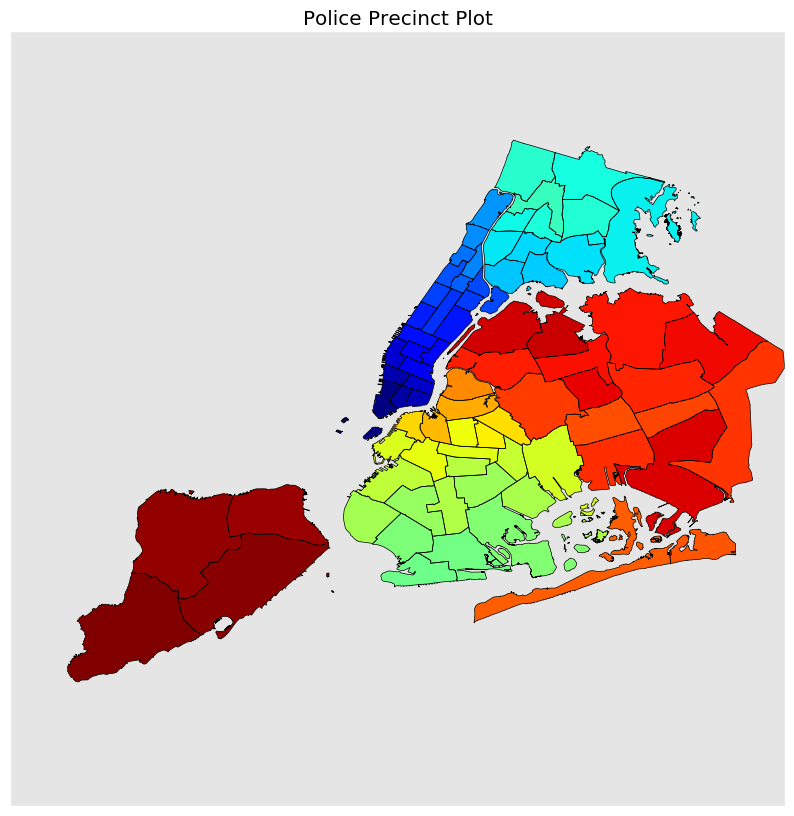

In [40]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
precinct.plot(column='precinct',alpha=1,linewidth=0.5,ax=ax)
plt.title("Police Precinct Plot")

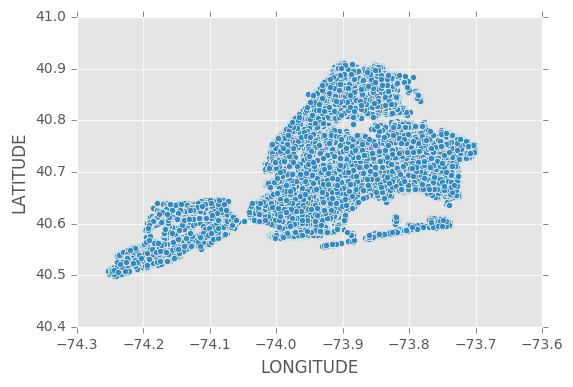

In [41]:
fig = plt.figure(figsize=(10,10))
mpl.rcParams['agg.path.chunksize'] = 10000
vehicledata.plot.scatter(x="LONGITUDE", y="LATITUDE")

In [133]:
from geopy.distance import vincenty

In [43]:
vehicledata["precinct"] = 0

In [44]:
a=[]

In [45]:
index = []

In [46]:
for i in range(len(vehicledata)):
    try:
        a.append(precinct[precinct.geometry.intersects(vehicledata.iloc[i,:].geometry)]["precinct"].values[0])
    except IndexError:
        a.append(0)
        index.append(i)
    print ("\r %f " %(i*100/len(vehicledata)), end="")

 99.999862 

In [47]:
vehicledata["precinct"] = a

In [48]:
crimedata.head()

,Occurrence Date,Offense Classification,Precinct,Borough,longitude,latitude,lonlat,geometry
0,1940-09-06 19:30:00,FELONY,66.0,BROOKLYN,-73.988373,40.622703,"(-73.9883732929999, 40.6227027620001)",POINT (-73.9883732929999 40.6227027620001)
1,1968-12-14 00:20:00,FELONY,28.0,MANHATTAN,-73.955862,40.803753,"(-73.955861904, 40.8037530600001)",POINT (-73.955861904 40.8037530600001)
2,1970-10-30 15:30:00,FELONY,84.0,BROOKLYN,-73.991859,40.688874,"(-73.9918594329999, 40.688874254)",POINT (-73.9918594329999 40.688874254)
3,1972-07-18 23:00:00,FELONY,73.0,BROOKLYN,-73.922046,40.667414,"(-73.9220463899999, 40.6674141890001)",POINT (-73.92204638999991 40.6674141890001)
4,1987-05-21 00:01:00,FELONY,75.0,BROOKLYN,-73.878495,40.666899,"(-73.878495425, 40.6668988440001)",POINT (-73.878495425 40.6668988440001)


In [49]:
vehicledata.head()

,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,geometry,precinct
DATE,,,,,,,,,,,,,,,,,,,
2015-08-25,19:00,NaN,NaN,40.732941,-73.920382,"(-73.9203819, 40.7329414)",NaN,NaN,NaN,0,0,0,0,0,0,0,0,POINT (-73.9203819 40.7329414),108.0
2016-07-27,7:35,BROOKLYN,11208.0,40.671341,-73.881939,"(-73.88193940000001, 40.6713407)",SUTTER AVENUE,LINWOOD STREET,NaN,0,0,0,0,0,0,0,0,POINT (-73.88193940000001 40.6713407),75.0
2016-06-19,7:24,QUEENS,11385.0,40.713811,-73.920595,"(-73.92059470000001, 40.7138108)",NaN,NaN,47-05 METROPOLITAN AVENUE,0,0,0,0,0,0,0,0,POINT (-73.92059470000001 40.7138108),104.0
2016-06-19,8:30,BROOKLYN,11208.0,40.680283,-73.866604,"(-73.86660429999999, 40.680282899999995)",NaN,NaN,418 GRANT AVENUE,0,0,0,0,0,0,0,0,POINT (-73.86660429999999 40.68028289999999),75.0
2016-06-19,8:50,QUEENS,11357.0,40.789460,-73.807622,"(-73.8076224, 40.7894601)",154 STREET,14 AVENUE,NaN,1,0,1,0,0,0,0,0,POINT (-73.8076224 40.7894601),109.0


In [50]:
vehicleprecinct = vehicledata[vehicledata["precinct"] != 0]

In [54]:
def delfunc(data):
    prec = precinct[precinct.geometry.intersects(data.geometry)]["precinct"].values
    if prec and prec[0]==data.Precinct:
        return 1
    else:
        return 0

In [56]:
crimedata["flag"] = crimedata.apply(delfunc, axis=1)

In [57]:
crimeprecinct = crimedata[crimedata.flag==1]

In [58]:
crimeprecinct.shape

(1076029, 9)

In [326]:
crimegroup = crimeprecinct.groupby(crimeprecinct.Precinct)

In [327]:
precinctgroups = vehicleprecinct.groupby(vehicleprecinct["precinct"])

In [61]:
centroids_lon = []
centroids_lat = []
for i in precinct.precinct:
    lat_temp = np.r_[precinctgroups.get_group(i).LATITUDE.values, crimegroup.get_group(i).latitude.values].mean()
    lon_temp = np.r_[precinctgroups.get_group(i).LONGITUDE.values, crimegroup.get_group(i).longitude.values].mean()
    centroids_lon.append(lon_temp)
    centroids_lat.append(lat_temp)

In [62]:
precinct["station_lat"] = centroids_lat
precinct["station_lon"] = centroids_lon

In [63]:
precinct.head()

,geometry,precinct,shape_area,shape_leng,station_lat,station_lon
0,(POLYGON ((-74.0438776157395 40.69018767637665...,1.0,4.718216e+07,79979.409545,40.715649,-74.007486
1,POLYGON ((-73.98863862848766 40.72293372026369...,5.0,1.808880e+07,18676.124259,40.717824,-73.996539
2,POLYGON ((-73.99968392160721 40.73855224865976...,6.0,2.213193e+07,27182.610113,40.733650,-74.001622
3,POLYGON ((-73.97345324119571 40.71896288708222...,7.0,1.836333e+07,17301.492549,40.716966,-73.985886
4,POLYGON ((-73.97160900246391 40.72672340116989...,9.0,2.139401e+07,19773.401872,40.726666,-73.985608


In [89]:
precinct.to_file("precinct_station.shp")

In [95]:
vehicledata.to_csv("vehicledata_precinct.csv")

In [96]:
crimeprecinct.to_csv("crimedata_precinct.csv")

# interupt point read from saved file

In [4]:
precinct = gp.GeoDataFrame.from_file("precinct_station.shp")

In [30]:
vehicleprecinct = gp.GeoDataFrame.from_csv("vehicledata_precinct.csv", parse_dates=["DATE"])

In [178]:
crimeprecinct = gp.GeoDataFrame.from_csv("crimedata_precinct.csv", parse_dates=["Occurrence Date"])

In [516]:
crimeprecinct.head()

,Occurrence Date,Offense Classification,Precinct,Borough,longitude,latitude,lonlat,geometry,flag,year
0,1940-09-06 19:30:00,FELONY,66.0,BROOKLYN,-73.988373,40.622703,"(-73.9883732929999, 40.6227027620001)",POINT (987477.6007920534 166144.0016966514),1,1940
1,1968-12-14 00:20:00,FELONY,28.0,MANHATTAN,-73.955862,40.803753,"(-73.955861904, 40.8037530600001)",POINT (996469.6004883961 232109.0149899167),1,1968
2,1970-10-30 15:30:00,FELONY,84.0,BROOKLYN,-73.991859,40.688874,"(-73.9918594329999, 40.688874254)",POINT (986507.5998470334 190252.0065712351),1,1970
3,1972-07-18 23:00:00,FELONY,73.0,BROOKLYN,-73.922046,40.667414,"(-73.9220463899999, 40.6674141890001)",POINT (1005875.603628567 182443.0055109292),1,1972
4,1987-05-21 00:01:00,FELONY,75.0,BROOKLYN,-73.878495,40.666899,"(-73.878495425, 40.6668988440001)",POINT (1017957.60614923 182269.0059629336),1,1987


In [519]:
vehicleprecinct = vehicleprecinct[vehicleprecinct["precinct"] != 0]

In [520]:
vehicleprecinct.head()

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,geometry,precinct,year
0,2015-08-25,19:00,NaN,NaN,40.732941,-73.920382,"(-73.9203819, 40.7329414)",NaN,NaN,NaN,...,0,0,0,0,0,0,0,POINT (1006315.661293584 206316.9244950273),108.0,2015
1,2016-07-27,7:35,BROOKLYN,11208.0,40.671341,-73.881939,"(-73.88193940000001, 40.6713407)",SUTTER AVENUE,LINWOOD STREET,NaN,...,0,0,0,0,0,0,0,POINT (1017000.003581842 183885.9920872763),75.0,2016
2,2016-06-19,7:24,QUEENS,11385.0,40.713811,-73.920595,"(-73.92059470000001, 40.7138108)",NaN,NaN,47-05 METROPOLITAN AVENUE,...,0,0,0,0,0,0,0,POINT (1006263.003171145 199347.0058042475),104.0,2016
3,2016-06-19,8:30,BROOKLYN,11208.0,40.680283,-73.866604,"(-73.86660429999999, 40.680282899999995)",NaN,NaN,418 GRANT AVENUE,...,0,0,0,0,0,0,0,POINT (1021248.99510605 187149.9935817005),75.0,2016
4,2016-06-19,8:50,QUEENS,11357.0,40.789460,-73.807622,"(-73.8076224, 40.7894601)",154 STREET,14 AVENUE,NaN,...,0,1,0,0,0,0,0,POINT (1037520.997517097 226957.0099468532),109.0,2016


In [182]:
crimeprecinct["lonlat"] = crimeprecinct["lonlat"].apply(broke)

In [183]:
crimeprecinct['geometry']=crimeprecinct['lonlat'].apply(lambda x:shapely.geometry.Point(x))

In [521]:
vehicleprecinct["LOCATION"] = vehicleprecinct["LOCATION"].apply(broke)
vehicleprecinct["geometry"] = vehicleprecinct["LOCATION"].apply(lambda x:shapely.geometry.Point(x))

TypeError: expected string or bytes-like object

In [136]:
vehicleprecinct.crs = from_epsg(4326)
crimeprecinct.crs = from_epsg(4326)

# #

In [11]:
precinct.head()

,geometry,precinct,shape_area,shape_leng,station_la,station_lo
0,(POLYGON ((-74.0438776157395 40.69018767637665...,1.0,4.718216e+07,79979.409545,40.715649,-74.007486
1,POLYGON ((-73.98863862848766 40.72293372026369...,5.0,1.808880e+07,18676.124259,40.717824,-73.996539
2,POLYGON ((-73.99968392160721 40.73855224865976...,6.0,2.213193e+07,27182.610113,40.733650,-74.001622
3,POLYGON ((-73.97345324119571 40.71896288708222...,7.0,1.836333e+07,17301.492549,40.716966,-73.985886
4,POLYGON ((-73.97160900246391 40.72672340116989...,9.0,2.139401e+07,19773.401872,40.726666,-73.985608


In [12]:
police = precinct[["station_lo", "station_la"]]

In [14]:
police["point"] = police.apply(lambda x : shapely.geometry.Point(x.station_lo, x.station_la), axis=1)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [68]:
police = gp.GeoDataFrame(police, geometry="point")

In [69]:
police.crs= from_epsg(4326)

In [70]:
c_s = pd.read_excel("NYPD.xlsx")

In [71]:
c_s["geometry"] = c_s.apply(lambda x: shapely.geometry.Point(x.Longitude, x.Latitude), axis=1)

In [72]:
current_station = gp.GeoDataFrame(c_s, geometry="geometry")

In [73]:
current_station.crs = from_epsg(4326)

In [74]:
current_station.head()

,Name of the police office,Borough,Address,ZipCode,Latitude,Longitude,geometry
0,1st Precinct,Manhattan,"16 Ericsson Pl, New York, NY",10013.0,40.720245,-74.007086,POINT (-74.007086 40.720245)
1,5th Precinct,Manhattan,"19 Elizabeth St, New York, NY",10013.0,40.716201,-73.997477,POINT (-73.997477 40.716201)
2,6th Precinct,Manhattan,"233 W 10th St, New York, NY",10014.0,40.734118,-74.005390,POINT (-74.00539000000001 40.734118)
3,7th Precinct,Manhattan,"19 1/2 Pitt St, New York, NY",10002.0,40.716362,-73.983934,POINT (-73.983934 40.716362)
4,9th Precinct,Manhattan,"321 E 5th St, New York, NY",10003.0,40.726538,-73.987820,POINT (-73.98782 40.726538)


In [75]:
precinct.head()

,geometry,precinct,shape_area,shape_leng,station_la,station_lo
0,(POLYGON ((-74.0438776157395 40.69018767637665...,1.0,4.718216e+07,79979.409545,40.715649,-74.007486
1,POLYGON ((-73.98863862848766 40.72293372026369...,5.0,1.808880e+07,18676.124259,40.717824,-73.996539
2,POLYGON ((-73.99968392160721 40.73855224865976...,6.0,2.213193e+07,27182.610113,40.733650,-74.001622
3,POLYGON ((-73.97345324119571 40.71896288708222...,7.0,1.836333e+07,17301.492549,40.716966,-73.985886
4,POLYGON ((-73.97160900246391 40.72672340116989...,9.0,2.139401e+07,19773.401872,40.726666,-73.985608


In [76]:
police["precinct"] = precinct.precinct

In [77]:
police.head()

,station_lo,station_la,point,precinct
0,-74.007486,40.715649,POINT (-74.00748580052003 40.71564925261436),1.0
1,-73.996539,40.717824,POINT (-73.99653907008316 40.71782354226078),5.0
2,-74.001622,40.733650,POINT (-74.00162161755709 40.73364966583085),6.0
3,-73.985886,40.716966,POINT (-73.98588611777255 40.71696573096882),7.0
4,-73.985608,40.726666,POINT (-73.98560803842241 40.7266661162632),9.0


In [177]:
police.to_csv("police.csv")

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


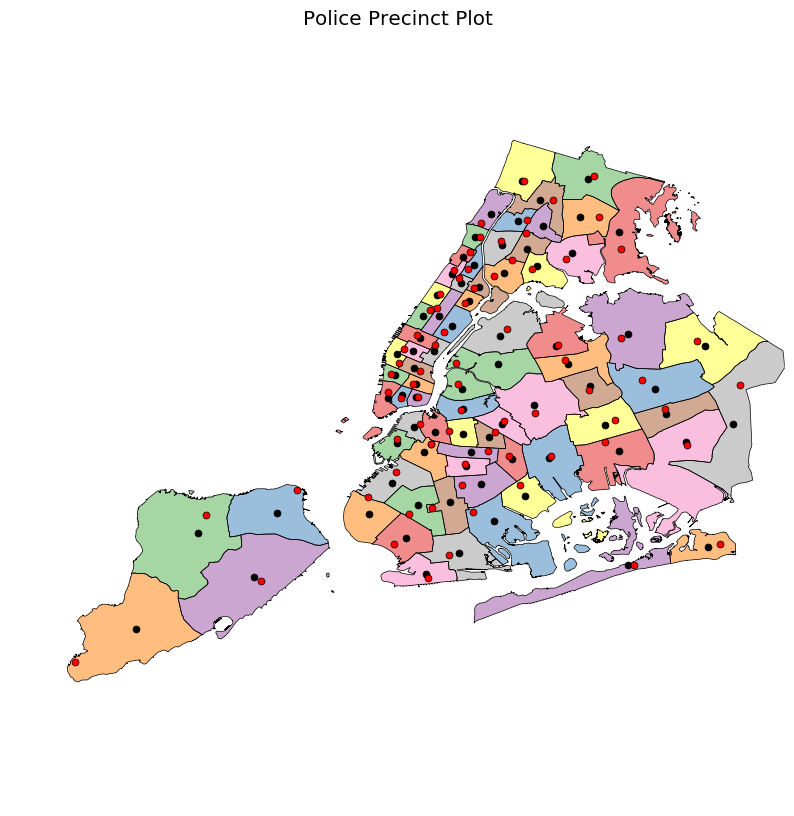

In [34]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
precinct["geometry"].plot( alpha=0.5,linewidth=0.5,ax=ax)
police.plot(ax=ax, markersize=5, color="black")
current_station.plot(ax=ax, markersize=5, color="red")
plt.title("Police Precinct Plot")
plt.legend(loc="upper left")
ax.set_axis_bgcolor('white') 
plt.show()
plt.savefig("police.png", dpi=400)

weighted average spatial analysis

In [152]:
precinct.head()

,geometry,precinct,shape_area,shape_leng,station_la,station_lo
0,(POLYGON ((-74.0438776157395 40.69018767637665...,1.0,4.718216e+07,79979.409545,40.715649,-74.007486
1,POLYGON ((-73.98863862848766 40.72293372026369...,5.0,1.808880e+07,18676.124259,40.717824,-73.996539
2,POLYGON ((-73.99968392160721 40.73855224865976...,6.0,2.213193e+07,27182.610113,40.733650,-74.001622
3,POLYGON ((-73.97345324119571 40.71896288708222...,7.0,1.836333e+07,17301.492549,40.716966,-73.985886
4,POLYGON ((-73.97160900246391 40.72672340116989...,9.0,2.139401e+07,19773.401872,40.726666,-73.985608


In [26]:
precinct_num = 84

In [169]:
crimeprecinct.head()

,Occurrence Date,Offense Classification,Precinct,Borough,longitude,latitude,lonlat,geometry,flag
0,1940-09-06 19:30:00,FELONY,66.0,BROOKLYN,-73.988373,40.622703,"(-73.9883732929999, 40.6227027620001)",POINT (-73.9883732929999 40.6227027620001),1
1,1968-12-14 00:20:00,FELONY,28.0,MANHATTAN,-73.955862,40.803753,"(-73.955861904, 40.8037530600001)",POINT (-73.955861904 40.8037530600001),1
2,1970-10-30 15:30:00,FELONY,84.0,BROOKLYN,-73.991859,40.688874,"(-73.9918594329999, 40.688874254)",POINT (-73.9918594329999 40.688874254),1
3,1972-07-18 23:00:00,FELONY,73.0,BROOKLYN,-73.922046,40.667414,"(-73.9220463899999, 40.6674141890001)",POINT (-73.92204638999991 40.6674141890001),1
4,1987-05-21 00:01:00,FELONY,75.0,BROOKLYN,-73.878495,40.666899,"(-73.878495425, 40.6668988440001)",POINT (-73.878495425 40.6668988440001),1


In [48]:
vehiclegroup = vehicleprecinct.groupby(vehicleprecinct.precinct)
crimegroup = crimeprecinct.groupby(crimeprecinct.Precinct)

In [49]:
precinct108_vechicle = gp.GeoDataFrame(vehiclegroup.get_group(precinct_num), geometry="geometry")
precinct108_crime = gp.GeoDataFrame(crimegroup.get_group(precinct_num), geometry="geometry")

In [50]:
precinct108_crime.crs = from_epsg(4326)
precinct108_vechicle.crs = from_epsg(4326)

In [67]:
current_station.head()

,Name of the police office,Borough,Address,ZipCode,Latitude,Longitude,geometry
0,1st Precinct,Manhattan,"16 Ericsson Pl, New York, NY",10013.0,40.720245,-74.007086,POINT (-74.007086 40.720245)
1,5th Precinct,Manhattan,"19 Elizabeth St, New York, NY",10013.0,40.716201,-73.997477,POINT (-73.997477 40.716201)
2,6th Precinct,Manhattan,"233 W 10th St, New York, NY",10014.0,40.734118,-74.005390,POINT (-74.00539000000001 40.734118)
3,7th Precinct,Manhattan,"19 1/2 Pitt St, New York, NY",10002.0,40.716362,-73.983934,POINT (-73.983934 40.716362)
4,9th Precinct,Manhattan,"321 E 5th St, New York, NY",10003.0,40.726538,-73.987820,POINT (-73.98782 40.726538)


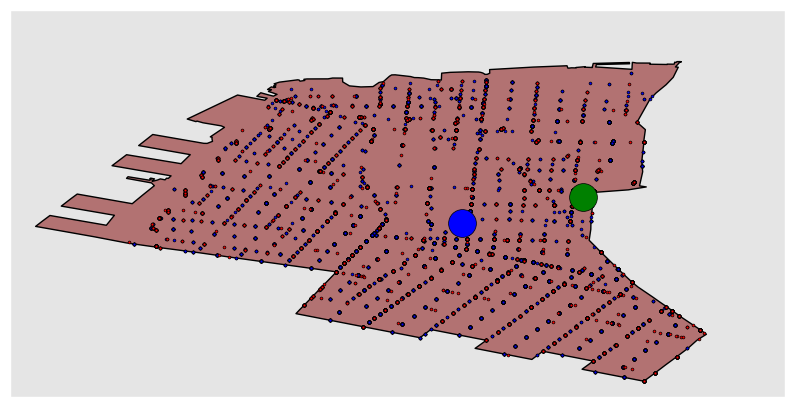

In [86]:
f, ax = plt.subplots(figsize=(10,5))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
precinct[precinct.precinct==precinct_num].plot(ax=ax)
precinct108_crime.plot(ax=ax, color="blue")
precinct108_vechicle.plot(ax=ax, color="red")
police[police.precinct==precinct_num].plot(ax=ax, markersize=20, color="blue")
current_station[current_station["Name of the police office"]=="84th Precinct "].plot(ax=ax, markersize=20, color="green")

for different type built a spatial pattern and use moran's I

In [144]:
vehicleprecinct = gp.GeoDataFrame(vehicleprecinct, geometry="geometry")

In [184]:
crimeprecinct = gp.GeoDataFrame(crimeprecinct, geometry="geometry")

In [174]:
vehicleprecinct.crs = from_epsg(4326)
crimeprecinct = from_epsg(4326)

In [150]:
vehicleprecinct = vehicleprecinct.to_crs(epsg=2263)

In [186]:
vehicleprecinct.head()

,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,geometry,precinct
DATE,,,,,,,,,,,,,,,,,,,
2015-08-25,19:00,NaN,NaN,40.732941,-73.920382,"(-73.9203819, 40.7329414)",NaN,NaN,NaN,0,0,0,0,0,0,0,0,POINT (1006315.661293584 206316.9244950273),108.0
2016-07-27,7:35,BROOKLYN,11208.0,40.671341,-73.881939,"(-73.88193940000001, 40.6713407)",SUTTER AVENUE,LINWOOD STREET,NaN,0,0,0,0,0,0,0,0,POINT (1017000.003581842 183885.9920872763),75.0
2016-06-19,7:24,QUEENS,11385.0,40.713811,-73.920595,"(-73.92059470000001, 40.7138108)",NaN,NaN,47-05 METROPOLITAN AVENUE,0,0,0,0,0,0,0,0,POINT (1006263.003171145 199347.0058042475),104.0
2016-06-19,8:30,BROOKLYN,11208.0,40.680283,-73.866604,"(-73.86660429999999, 40.680282899999995)",NaN,NaN,418 GRANT AVENUE,0,0,0,0,0,0,0,0,POINT (1021248.99510605 187149.9935817005),75.0
2016-06-19,8:50,QUEENS,11357.0,40.789460,-73.807622,"(-73.8076224, 40.7894601)",154 STREET,14 AVENUE,NaN,1,0,1,0,0,0,0,0,POINT (1037520.997517097 226957.0099468532),109.0


In [195]:
crimeprecinct.crs = from_epsg(4326)

In [197]:
crimeprecinct = crimeprecinct.to_crs(epsg=2263)

In [196]:
crimeprecinct.head()

,Occurrence Date,Offense Classification,Precinct,Borough,longitude,latitude,lonlat,geometry,flag
0,1940-09-06 19:30:00,FELONY,66.0,BROOKLYN,-73.988373,40.622703,"(-73.9883732929999, 40.6227027620001)",POINT (-73.9883732929999 40.6227027620001),1
1,1968-12-14 00:20:00,FELONY,28.0,MANHATTAN,-73.955862,40.803753,"(-73.955861904, 40.8037530600001)",POINT (-73.955861904 40.8037530600001),1
2,1970-10-30 15:30:00,FELONY,84.0,BROOKLYN,-73.991859,40.688874,"(-73.9918594329999, 40.688874254)",POINT (-73.9918594329999 40.688874254),1
3,1972-07-18 23:00:00,FELONY,73.0,BROOKLYN,-73.922046,40.667414,"(-73.9220463899999, 40.6674141890001)",POINT (-73.92204638999991 40.6674141890001),1
4,1987-05-21 00:01:00,FELONY,75.0,BROOKLYN,-73.878495,40.666899,"(-73.878495425, 40.6668988440001)",POINT (-73.878495425 40.6668988440001),1


In [275]:
crimeprecinct.head()

,Occurrence Date,Offense Classification,Precinct,Borough,longitude,latitude,lonlat,geometry,flag
0,1940-09-06 19:30:00,FELONY,66.0,BROOKLYN,-73.988373,40.622703,"(-73.9883732929999, 40.6227027620001)",POINT (987477.6007920534 166144.0016966514),1
1,1968-12-14 00:20:00,FELONY,28.0,MANHATTAN,-73.955862,40.803753,"(-73.955861904, 40.8037530600001)",POINT (996469.6004883961 232109.0149899167),1
2,1970-10-30 15:30:00,FELONY,84.0,BROOKLYN,-73.991859,40.688874,"(-73.9918594329999, 40.688874254)",POINT (986507.5998470334 190252.0065712351),1
3,1972-07-18 23:00:00,FELONY,73.0,BROOKLYN,-73.922046,40.667414,"(-73.9220463899999, 40.6674141890001)",POINT (1005875.603628567 182443.0055109292),1
4,1987-05-21 00:01:00,FELONY,75.0,BROOKLYN,-73.878495,40.666899,"(-73.878495425, 40.6668988440001)",POINT (1017957.60614923 182269.0059629336),1


In [277]:
current_station_copy = current_station.copy()

In [279]:
current_station_copy = current_station_copy.to_crs(epsg=2263)

In [236]:
current_station_copy["geometry"] = current_station_copy.apply(lambda x:x.geometry.buffer(1640.42), axis=1)

In [247]:
from geopy.distance import vincenty, great_circle

In [282]:
police_copy = police.to_crs(epsg=2263)

In [289]:
df = gp.GeoDataFrame({"current":current_station_copy.geometry, "new":police_copy.point, "precinct": police_copy["precinct"]})

In [290]:
df["distance(miles)"] = df.apply(lambda x: x.current.distance(x.new)/5280, axis=1)

In [302]:
df["area"] = precinct.to_crs(epsg=2263).geometry.area/(2.788*10**7)

In [303]:
df.head()

,current,new,precinct,distance(miles),area
0,POINT (982285.7847114966 201681.2836886017),POINT (982174.8182698902 200006.9215284435),1.0,0.317810,1.692328
1,POINT (984949.409522805 200207.8613308444),POINT (985209.3929507392 200799.0119260657),5.0,0.122310,0.648809
2,POINT (982756.2211909849 206735.6148771414),POINT (983800.5834935118 206564.9442424791),6.0,0.200420,0.793828
3,POINT (988703.7004316385 200266.9168927576),POINT (988162.5130130752 200486.7812942572),7.0,0.110633,0.658645
4,POINT (987625.9360974137 203974.1730681803),POINT (988239.0188122966 204020.9427848187),9.0,0.116452,0.767356


In [1064]:
population = pd.read_excel("population.xlsx")

In [1066]:
population.sort("Precinct", ascending=True, inplace=1)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [1067]:
population.reset_index(drop=1, inplace=1)

In [1068]:
df["population"] = population.Population

In [322]:
df["density"] = df.population/df.area

In [1069]:
df.head()

,current,new,precinct,distance(miles),area,population,density,metric,eventcount,disarea
0,POINT (982285.7847114966 201681.2836886017),POINT (982174.8182698902 200006.9215284435),1.0,0.317810,1.692328,66679,52595.605508,68421.358147,15104,0.244301
1,POINT (984949.409522805 200207.8613308444),POINT (985209.3929507392 200799.0119260657),5.0,0.122310,0.648809,52683,130753.404742,105320.151623,11418,0.151845
2,POINT (982756.2211909849 206735.6148771414),POINT (983800.5834935118 206564.9442424791),6.0,0.200420,0.793828,62226,120707.476106,107546.785484,10884,0.224945
3,POINT (988703.7004316385 200266.9168927576),POINT (988162.5130130752 200486.7812942572),7.0,0.110633,0.658645,56240,127719.754377,103653.466791,6469,0.136320
4,POINT (987625.9360974137 203974.1730681803),POINT (988239.0188122966 204020.9427848187),9.0,0.116452,0.767356,76443,179791.292646,157495.161509,10428,0.132937


In [335]:
crimeprecinct["year"] = crimeprecinct["Occurrence Date"].dt.year

In [350]:
vehicleprecinct.head()

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,geometry,precinct,year
0,2015-08-25,19:00,NaN,NaN,40.732941,-73.920382,"(-73.9203819, 40.7329414)",NaN,NaN,NaN,...,0,0,0,0,0,0,0,POINT (1006315.661293584 206316.9244950273),108.0,2015
1,2016-07-27,7:35,BROOKLYN,11208.0,40.671341,-73.881939,"(-73.88193940000001, 40.6713407)",SUTTER AVENUE,LINWOOD STREET,NaN,...,0,0,0,0,0,0,0,POINT (1017000.003581842 183885.9920872763),75.0,2016
2,2016-06-19,7:24,QUEENS,11385.0,40.713811,-73.920595,"(-73.92059470000001, 40.7138108)",NaN,NaN,47-05 METROPOLITAN AVENUE,...,0,0,0,0,0,0,0,POINT (1006263.003171145 199347.0058042475),104.0,2016
3,2016-06-19,8:30,BROOKLYN,11208.0,40.680283,-73.866604,"(-73.86660429999999, 40.680282899999995)",NaN,NaN,418 GRANT AVENUE,...,0,0,0,0,0,0,0,POINT (1021248.99510605 187149.9935817005),75.0,2016
4,2016-06-19,8:50,QUEENS,11357.0,40.789460,-73.807622,"(-73.8076224, 40.7894601)",154 STREET,14 AVENUE,NaN,...,0,1,0,0,0,0,0,POINT (1037520.997517097 226957.0099468532),109.0,2016


In [338]:
vehicleprecinct.reset_index(inplace=1)

TypeError: 'NoneType' object is not subscriptable

In [341]:
vehicleprecinct["year"] = vehicleprecinct["DATE"].dt.year

In [523]:
vehicleyear = vehicleprecinct.groupby(vehicleprecinct.year)
crimeyear = crimeprecinct.groupby(crimeprecinct.year)

In [368]:
crime2015 = pd.concat(crimeyear.get_group(gp) for gp in crimeyear.groups if gp <= 2005)

In [524]:
dic={}

In [525]:
for i in range(2006, 2017):
    temp = {}
    for j in precinct.precinct:
        try:
            crime_temp_lon = crimeyear.get_group(i).groupby(crimeprecinct.Precinct).get_group(j).longitude.values
            crime_temp_lat = crimeyear.get_group(i).groupby(crimeprecinct.Precinct).get_group(j).latitude.values
        except KeyError:
            crime_temp_lat = []
            crime_temp_lon = []
        try:
            vehicle_temp_lat = vehicleyear.get_group(i).groupby(vehicleprecinct.precinct).get_group(j).LATITUDE.values
            vehicle_temp_lon = vehicleyear.get_group(i).groupby(vehicleprecinct.precinct).get_group(j).LONGITUDE.values
        except KeyError:
            vehicle_temp_lat = []
            vehicle_temp_lon = []
        temp_lon = np.r_[crime_temp_lon, vehicle_temp_lon].mean()
        temp_lat = np.r_[crime_temp_lat, vehicle_temp_lat].mean()
        temp.update({j:(temp_lon, temp_lat)})
    dic[i] = temp

In [595]:
for yy in range(2012,2016):
    temp = {}
    for i in precinct.precinct:
        lat_temp = np.r_[vehicleyear.get_group(yy).groupby(vehicleprecinct.precinct).get_group(i).LATITUDE.values, 
                         crimeyear.get_group(yy).groupby(crimeprecinct.Precinct).get_group(i).latitude.values].mean()
        lon_temp = np.r_[vehicleyear.get_group(yy).groupby(vehicleprecinct.precinct).get_group(i).LONGITUDE.values, 
                         crimeyear.get_group(yy).groupby(crimeprecinct.Precinct).get_group(i).longitude.values].mean()
        temp.update({i:(lon_temp, lat_temp)})
    dic[yy] = temp

In [528]:
crime2015group = crime2015.groupby(crime2015.Precinct)

In [529]:
dic_temp = {}
for i in crime2015.Precinct:
    temp_lon = crime2015group.get_group(i).longitude.values.mean()
    temp_lat = crime2015group.get_group(i).latitude.values.mean()
    dic_temp[i] = (temp_lon, temp_lat)

In [530]:
dic[2005] = dic_temp

In [921]:
yy = 2016

2015

In [610]:
temp = {}
for i in precinct.precinct:
    lat_temp = np.r_[vehicleyear.get_group(yy).groupby(vehicleprecinct.precinct).get_group(i).LATITUDE.values].mean()
    lon_temp = np.r_[vehicleyear.get_group(yy).groupby(vehicleprecinct.precinct).get_group(i).LONGITUDE.values].mean()
    temp.update({i:(lon_temp, lat_temp)})
dic[2016] = temp

In [596]:
latlon_dic = dic.copy()

In [611]:
latlon_df = pd.DataFrame([(k,k1,v1) for k,v in dic.items() for k1,v1 in v.items()], columns = ['year','precint','latlon'])

In [612]:
latlon_df.head()

,year,precint,latlon
0,2016,1.0,"(-74.0083702678, 40.7154872488)"
1,2016,5.0,"(-73.9965622098, 40.7178431214)"
2,2016,6.0,"(-74.0020466395, 40.7340138815)"
3,2016,7.0,"(-73.9859377881, 40.7169101744)"
4,2016,9.0,"(-73.9861986486, 40.7266374176)"


In [613]:
latlon_df = latlon_df.pivot(index="precint", columns="year", values="latlon")

In [614]:
latlon_df.reset_index(inplace=1)

In [615]:
latlon_df.ix[:,1:] = latlon_df.ix[:,1:].applymap(lambda x:shapely.geometry.Point(x))

#### event center for each year per precinct

In [616]:
latlon_df.head()

year,precint,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,1.0,POINT (-74.00832198281476 40.71445210086425),POINT (-74.00709657650621 40.71543888002459),POINT (-74.00702530082755 40.71537391268716),POINT (-74.00698663200234 40.71535015032394),POINT (-74.00697332325824 40.71539837991398),POINT (-74.00678721156589 40.71610140686822),POINT (-74.00687159370325 40.71560425361204),POINT (-74.00715129180931 40.71619524411778),POINT (-74.00776802543645 40.71594892637451),POINT (-74.00794869463284 40.71557323629871),POINT (-74.00798751678944 40.7153142943506),POINT (-74.00837026781485 40.71548724879799)
1,5.0,POINT (-73.99702085844442 40.71761649547229),POINT (-73.99664485245808 40.71796617095413),POINT (-73.9965284575775 40.71787229424739),POINT (-73.99655802153808 40.71762309344886),POINT (-73.99655436767033 40.71786938965195),POINT (-73.99638883688728 40.71806612595471),POINT (-73.99651567200775 40.7178521016529),POINT (-73.99651884873768 40.7176836957348),POINT (-73.99640604749681 40.71774684769864),POINT (-73.99655979514432 40.71803011476036),POINT (-73.99651116314693 40.71785527881001),POINT (-73.99656220978594 40.71784312140674)
2,6.0,POINT (-74.00163417109998 40.73320001712005),POINT (-74.00108036354899 40.73328892890817),POINT (-74.00120592668668 40.73339401586041),POINT (-74.00151189499094 40.73338385850619),POINT (-74.00115234223941 40.73326085620327),POINT (-74.0012237863241 40.73332048983218),POINT (-74.00159657762853 40.7337375193942),POINT (-74.00209865641661 40.73399238488764),POINT (-74.00172123427973 40.73376423199063),POINT (-74.00183920360476 40.73388158344623),POINT (-74.001890664485 40.73381317708176),POINT (-74.00204663950953 40.73401388153951)
3,7.0,POINT (-73.98438668192102 40.71609469163165),POINT (-73.98570265810854 40.71695909181067),POINT (-73.9857216698927 40.71689685907157),POINT (-73.98579769058233 40.71686404461484),POINT (-73.98586783648014 40.7169588619839),POINT (-73.98586044678683 40.71720536363802),POINT (-73.98588458361219 40.7171086194475),POINT (-73.98599642765613 40.71676765552764),POINT (-73.98596494811589 40.71706301636904),POINT (-73.98600738032745 40.71692035533374),POINT (-73.98591672941016 40.71699155357783),POINT (-73.98593778806419 40.71691017442327)
4,9.0,POINT (-73.98552733034614 40.72698500167313),POINT (-73.98513044547927 40.72661665778601),POINT (-73.98499267222988 40.72659408273815),POINT (-73.98512490371647 40.72647288553171),POINT (-73.98537032697593 40.72675920054775),POINT (-73.98528861816196 40.72681886630846),POINT (-73.98513539426091 40.72668117133497),POINT (-73.98569144098487 40.72672451400645),POINT (-73.98601276403262 40.7266496951969),POINT (-73.98587289835838 40.72651836729362),POINT (-73.98584831758799 40.72682353417113),POINT (-73.98619864856953 40.72663741756487)


In [617]:
latlon_df.to_csv("latlon_year.csv")

In [434]:
df["metric"] = df.population/np.sqrt(df.area)

In [657]:
precinct_count = {}
for j in precinct.precinct:
    amount = 0
    for  i in range(2012,2016):
        amount += crimeyear.get_group(i).groupby(crimeprecinct.Precinct).get_group(j).count().values[0]
        amount += vehicleyear.get_group(i).groupby(vehicleprecinct.precinct).get_group(j).count().values[0]
    precinct_count[j] = amount

In [662]:
df["eventcount"] = precinct_count.values()

In [664]:
df["disarea"] = df["distance(miles)"]/np.sqrt(df.area)

In [665]:
df.head()

,current,new,precinct,distance(miles),area,population,density,metric,eventcount,disarea
0,POINT (982285.7847114966 201681.2836886017),POINT (982174.8182698902 200006.9215284435),1.0,0.317810,1.692328,89009.0,52595.605508,68421.358147,15104,0.244301
1,POINT (984949.409522805 200207.8613308444),POINT (985209.3929507392 200799.0119260657),5.0,0.122310,0.648809,84834.0,130753.404742,105320.151623,11418,0.151845
2,POINT (982756.2211909849 206735.6148771414),POINT (983800.5834935118 206564.9442424791),6.0,0.200420,0.793828,95821.0,120707.476106,107546.785484,10884,0.224945
3,POINT (988703.7004316385 200266.9168927576),POINT (988162.5130130752 200486.7812942572),7.0,0.110633,0.658645,84122.0,127719.754377,103653.466791,6469,0.136320
4,POINT (987625.9360974137 203974.1730681803),POINT (988239.0188122966 204020.9427848187),9.0,0.116452,0.767356,137964.0,179791.292646,157495.161509,10428,0.132937


In [677]:
df.sort("eventcount", ascending=0)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,current,new,precinct,distance(miles),area,population,density,metric,eventcount,disarea
46,POINT (1017128.379566744 183807.5797308587),POINT (1016807.21766438 183250.6746340888),75.0,0.121757,6.567417,NaN,NaN,NaN,30121,0.047511
62,POINT (1057654.965555802 203964.6732112519),POINT (1056209.189709119 192983.3641016559),105.0,2.097741,12.458278,229155.0,18393.793387,64923.260266,26433,0.594324
66,POINT (1032101.048873891 217044.5265709655),POINT (1033714.06831436 218128.9488929783),109.0,0.368117,11.574051,261695.0,22610.493641,76922.383826,26015,0.108204
10,POINT (994302.1174987858 218750.7783899898),POINT (996012.4035322065 220323.2242252214),19.0,0.440017,1.748113,216287.0,123725.970403,163585.815279,24588,0.332801
9,POINT (988377.1848545833 217953.7081446161),POINT (989041.6234661718 216991.0809508102),18.0,0.221529,1.157831,81502.0,70391.955424,75743.548576,24465,0.205877
7,POINT (985680.9969470496 213953.7548288819),POINT (987677.070011718 213391.2497743858),14.0,0.392768,0.735659,54124.0,73572.163158,63103.246816,24140,0.457929
71,POINT (1007716.254172114 219565.9487147785),POINT (1006275.720162459 217542.0236913811),114.0,0.470499,6.456170,NaN,NaN,NaN,20367,0.185170
39,POINT (998056.7264769219 175612.6455314827),POINT (1002295.740730483 175891.2929430518),67.0,0.804576,3.362438,210553.0,62619.155862,114824.436093,19504,0.438773
29,POINT (1026412.781294678 262655.8992727082),POINT (1024987.916613318 262014.0492880856),47.0,0.295977,5.757924,211983.0,36815.873085,88342.171267,19074,0.123346
65,POINT (996790.7958401828 209990.4682681813),POINT (1005833.766697545 209792.2575815622),108.0,1.713095,5.007207,128141.0,25591.311030,57265.139366,18721,0.765568


In [666]:
from scipy import stats

In [675]:
stats.spearmanr(df.eventcount.values, df["distance(miles)"].values)

SpearmanrResult(correlation=0.1164099058835901, pvalue=0.31334997418097693)

In [448]:
colors = cm.spectral(np.linspace(0, 1, len(latlon_df)))

In [540]:
latlon_df.crs = from_epsg(4326)

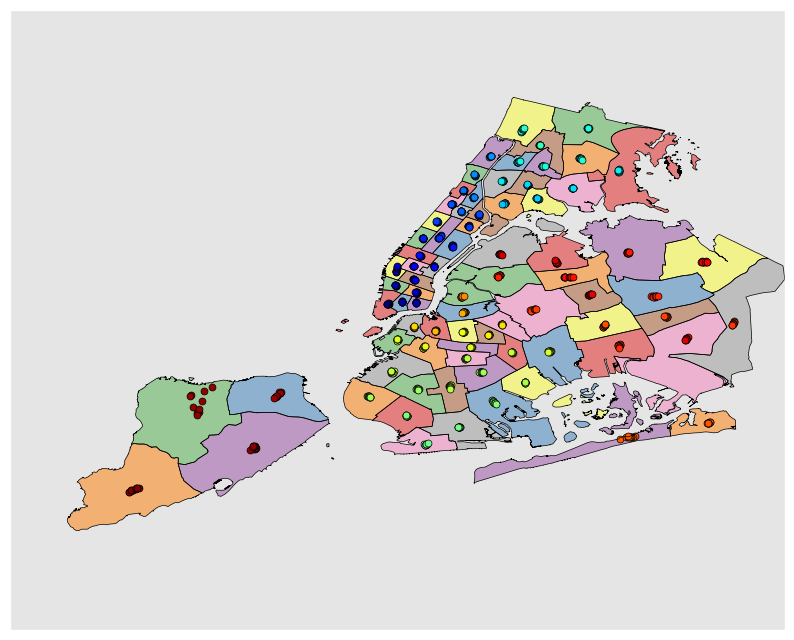

In [620]:
f, ax = plt.subplots(figsize=(10,8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for i in range(2006,2017):
    latlon_df.set_geometry(i).plot(column="precint", markersize=5, ax=ax)
precinct["geometry"].plot(alpha=0.5,linewidth=0.5,ax=ax)

In [731]:
def midpoint(data):
    lat = 0
    lon = 0
    for i in range(2005,2017):
        lon += data[i].x
        lat += data[i].y
    lon = lon/12.0
    lat = lat/12.0
    return shapely.geometry.Point(lon, lat)

In [735]:
latlon_df["mid"] = latlon_df.apply(midpoint, axis=1)

In [750]:
latlon_df.head()

year,precint,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,mid
0,1.0,POINT (-74.00832198281476 40.71445210086425),POINT (-74.00709657650621 40.71543888002459),POINT (-74.00702530082755 40.71537391268716),POINT (-74.00698663200234 40.71535015032394),POINT (-74.00697332325824 40.71539837991398),POINT (-74.00678721156589 40.71610140686822),POINT (-74.00687159370325 40.71560425361204),POINT (-74.00715129180931 40.71619524411778),POINT (-74.00776802543645 40.71594892637451),POINT (-74.00794869463284 40.71557323629871),POINT (-74.00798751678944 40.7153142943506),POINT (-74.00837026781485 40.71548724879799),POINT (-74.0074407014301 40.71551983618615)
1,5.0,POINT (-73.99702085844442 40.71761649547229),POINT (-73.99664485245808 40.71796617095413),POINT (-73.9965284575775 40.71787229424739),POINT (-73.99655802153808 40.71762309344886),POINT (-73.99655436767033 40.71786938965195),POINT (-73.99638883688728 40.71806612595471),POINT (-73.99651567200775 40.7178521016529),POINT (-73.99651884873768 40.7176836957348),POINT (-73.99640604749681 40.71774684769864),POINT (-73.99655979514432 40.71803011476036),POINT (-73.99651116314693 40.71785527881001),POINT (-73.99656220978594 40.71784312140674),POINT (-73.99656409424126 40.71783539414941)
2,6.0,POINT (-74.00163417109998 40.73320001712005),POINT (-74.00108036354899 40.73328892890817),POINT (-74.00120592668668 40.73339401586041),POINT (-74.00151189499094 40.73338385850619),POINT (-74.00115234223941 40.73326085620327),POINT (-74.0012237863241 40.73332048983218),POINT (-74.00159657762853 40.7337375193942),POINT (-74.00209865641661 40.73399238488764),POINT (-74.00172123427973 40.73376423199063),POINT (-74.00183920360476 40.73388158344623),POINT (-74.001890664485 40.73381317708176),POINT (-74.00204663950953 40.73401388153951),POINT (-74.00158345506786 40.73358757873086)
3,7.0,POINT (-73.98438668192102 40.71609469163165),POINT (-73.98570265810854 40.71695909181067),POINT (-73.9857216698927 40.71689685907157),POINT (-73.98579769058233 40.71686404461484),POINT (-73.98586783648014 40.7169588619839),POINT (-73.98586044678683 40.71720536363802),POINT (-73.98588458361219 40.7171086194475),POINT (-73.98599642765613 40.71676765552764),POINT (-73.98596494811589 40.71706301636904),POINT (-73.98600738032745 40.71692035533374),POINT (-73.98591672941016 40.71699155357783),POINT (-73.98593778806419 40.71691017442327),POINT (-73.98575373674647 40.71689502395247)
4,9.0,POINT (-73.98552733034614 40.72698500167313),POINT (-73.98513044547927 40.72661665778601),POINT (-73.98499267222988 40.72659408273815),POINT (-73.98512490371647 40.72647288553171),POINT (-73.98537032697593 40.72675920054775),POINT (-73.98528861816196 40.72681886630846),POINT (-73.98513539426091 40.72668117133497),POINT (-73.98569144098487 40.72672451400645),POINT (-73.98601276403262 40.7266496951969),POINT (-73.98587289835838 40.72651836729362),POINT (-73.98584831758799 40.72682353417113),POINT (-73.98619864856953 40.72663741756487),POINT (-73.98551614672532 40.72669011617943)


In [764]:
crime2015 = crimeyear.get_group(2015)
vehicle2015 = vehicleyear.get_group(2015)

In [773]:
current_station["precinct"] = precinct.precinct

In [805]:
current_station = current_station.set_geometry("geometry")

In [837]:
crime2015["center_1"] = crime2015.apply(lambda x :
                                                    current_station[current_station.precinct==x.Precinct].geometry.values[0]
                                                    , axis=1)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [995]:
crime2015["center_2"] = crime2015.apply(lambda x :
                                                    police[police.precinct==x.Precinct].point.values[0]
                                                    , axis=1)

In [845]:
vehicle2015["center_1"] = vehicle2015.apply(lambda x :current_station[current_station.precinct==x.precinct].geometry.values[0]
                                        , axis=1)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [997]:
vehicle2015["center_2"] = vehicle2015.apply(lambda x : police[police.precinct==x.precinct].point.values[0]
                                                    , axis=1)

In [999]:
def chcrs(data):
    for i in ["center_1", "center_2"]:
        data = data.set_geometry(i)
        data.crs = from_epsg(4326)
        data = data.to_crs(epsg=2263)
    return data

In [1000]:
crime2015 = chcrs(crime2015)

In [1001]:
vehicle2015 = chcrs(vehicle2015)

In [1003]:
crime2015["dis_1"] = crime2015.apply(lambda x: x["geometry"].distance(x["center_1"])/3280.84, axis=1)
crime2015["dis_2"] = crime2015.apply(lambda x: x["geometry"].distance(x["center_2"])/3280.84, axis=1)
vehicle2015["dis_1"] = vehicle2015.apply(lambda x: x["geometry"].distance(x["center_1"])/3280.84, axis=1)
vehicle2015["dis_2"] = vehicle2015.apply(lambda x: x["geometry"].distance(x["center_2"])/3280.84, axis=1)

In [1004]:
sumdis = pd.DataFrame(crime2015.dis_1.groupby(crime2015.Precinct).sum() + vehicle2015.dis_1.groupby(vehicle2015.precinct).sum())

In [1005]:
sumdis["dis_2"] = crime2015.dis_2.groupby(crime2015.Precinct).sum() + vehicle2015.dis_2.groupby(vehicle2015.precinct).sum()

In [1006]:
sumdis["events"] = crime2015.dis_1.groupby(crime2015.Precinct).count() + vehicle2015.dis_1.groupby(vehicle2015.precinct).count()

In [1007]:
sumdis["diff"] = sumdis.dis_1 - sumdis.dis_2

In [1008]:
sumdis["ratio"] = sumdis["diff"]/sumdis.dis_1

In [1009]:
sumdis["avesave"] = sumdis["diff"]/sumdis["events"]

In [1129]:
sumdis.sort("ratio", ascending=0).head()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,dis_1,dis_2,events,diff,ratio,avesave,dis_3,diff_2,ratio_2
Precinct,,,,,,,,,
79.0,8552.022648,2962.089611,3648,5589.933037,0.653639,1.532328,2957.333662,5594.688987,0.654195
123.0,10366.065760,5171.250563,2033,5194.815197,0.501137,2.555246,5160.181210,5205.884550,0.502204
108.0,14543.645340,7599.564944,5118,6944.080396,0.477465,1.356796,7588.472652,6955.172687,0.478228
48.0,4630.983347,2705.246800,3240,1925.736547,0.415838,0.594363,2709.016759,1921.966588,0.415023
42.0,3576.228883,2116.846853,2475,1459.382030,0.408078,0.589649,2114.584289,1461.644593,0.408711


# quest 2

In [1016]:
def func(data):
    df_temp = pd.DataFrame(columns=range(2013,2016))
    for i in range(2013,2016):
        df_temp[i] = data.get_group(i)["flag"].groupby(crimeprecinct.Precinct).count()
    return df_temp

In [1017]:
df1 = func(crimeyear)

In [1018]:
def func(data):
    df_temp = pd.DataFrame(columns=range(2013,2016))
    for i in range(2013,2016):
        df_temp[i] = data.get_group(i)["geometry"].groupby(vehicleprecinct.precinct).count()
    return df_temp

In [1019]:
df2 = func(vehicleyear)

In [1020]:
df_vc = df1/df2

In [1021]:
from sklearn.cluster import KMeans

In [1022]:
KM = KMeans(n_clusters=2)

In [1023]:
result = KM.fit(df_vc.values)

In [1024]:
df_vc["labels"] = result.labels_

In [1025]:
precinct["labels"] = result.labels_

In [1026]:
result.cluster_centers_

array([[ 0.53419762,  0.50099223,  0.45547475],
       [ 0.9788264 ,  1.01394472,  0.90457084]])

In [1130]:
ratio_ = result.cluster_centers_[:,2]

In [1160]:
ratio_ = np.array([0.2, 10])

### cluster 0: vehicle dominant, cluster 1: crime dominant

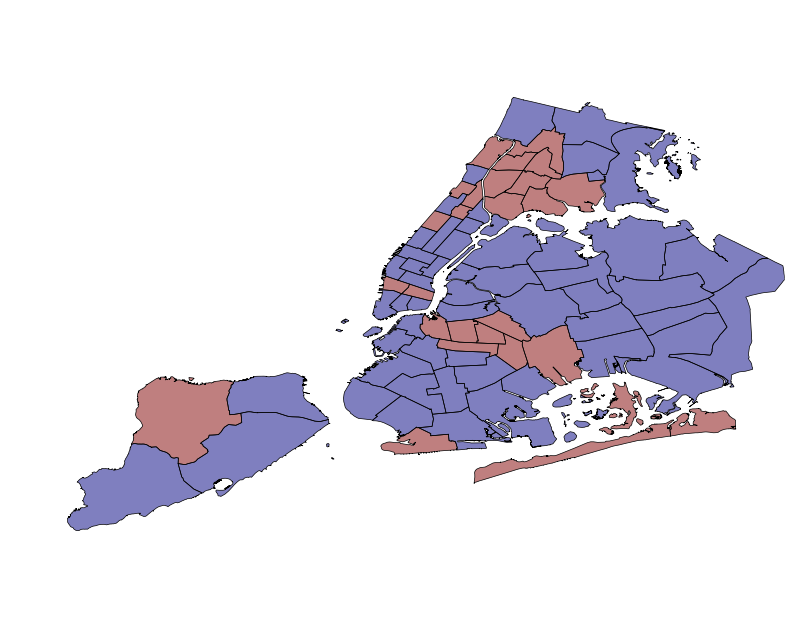

In [1028]:
f, ax = plt.subplots(figsize=(10,8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
precinct.plot(alpha=0.5,linewidth=0.5,ax=ax, column="labels")
ax.set_axis_bgcolor('white') 
plt.show()

In [1161]:
temp = {}
for i in precinct.precinct:
    ratio = ratio_[precinct[precinct.precinct==i]["labels"]]
    lat = []
    lon = []
    for yy in range(2012,2016):
        crime_temp = crimeyear.get_group(yy).groupby(crimeprecinct.Precinct).get_group(i)
        vehicle_temp = vehicleyear.get_group(yy).groupby(vehicleprecinct.precinct).get_group(i)
        lat_temp = (vehicle_temp.LATITUDE.values).sum() + (crime_temp.latitude.values).sum()*ratio
        lon_temp = (vehicle_temp.LONGITUDE.values).sum() + (crime_temp.longitude.values).sum()*ratio
        lat_temp = lat_temp/(len(vehicle_temp)+len(crime_temp)*ratio)
        lon_temp = lon_temp/(len(vehicle_temp)+len(crime_temp)*ratio)
        lat.append(lat_temp)
        lon.append(lon_temp)
    lat = np.mean(lat)
    lon = np.mean(lon)
    temp.update({i:(lon, lat)})

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


In [1146]:
vehicle2015["center_3"] = vehicle2015.apply(lambda x : shapely.geometry.Point(temp[x.precinct][0],temp[x.precinct][1]), axis=1)
crime2015["center_3"] = crime2015.apply(lambda x : shapely.geometry.Point(temp[x.Precinct][0],temp[x.Precinct][1]), axis=1)

In [1147]:
def chcrs(data):
    for i in ["center_3"]:
        data = data.set_geometry(i)
        data.crs = from_epsg(4326)
        data = data.to_crs(epsg=2263)
    return data

In [1148]:
crime2015 = chcrs(crime2015)
vehicle2015 = chcrs(vehicle2015)

In [1149]:
crime2015["dis_3"] = crime2015.apply(lambda x: x["geometry"].distance(x["center_3"])/3280.84, axis=1)
vehicle2015["dis_3"] = vehicle2015.apply(lambda x: x["geometry"].distance(x["center_3"])/3280.84, axis=1)

In [1150]:
sumdis["dis_3"] = crime2015.dis_3.groupby(crime2015.Precinct).sum() + vehicle2015.dis_3.groupby(vehicle2015.precinct).sum()

In [1151]:
sumdis["diff_2"] = sumdis.dis_1 - sumdis.dis_3

In [1152]:
sumdis["ratio_2"] = sumdis.diff_2/sumdis.dis_1

In [1153]:
sumdis.sort("ratio_2", ascending=0).head()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,dis_1,dis_2,events,diff,ratio,avesave,dis_3,diff_2,ratio_2
Precinct,,,,,,,,,
79.0,8552.022648,2962.089611,3648,5589.933037,0.653639,1.532328,2960.170151,5591.852498,0.653863
123.0,10366.065760,5171.250563,2033,5194.815197,0.501137,2.555246,5160.189883,5205.875877,0.502204
108.0,14543.645340,7599.564944,5118,6944.080396,0.477465,1.356796,7588.488737,6955.156603,0.478226
48.0,4630.983347,2705.246800,3240,1925.736547,0.415838,0.594363,2705.853865,1925.129483,0.415706
42.0,3576.228883,2116.846853,2475,1459.382030,0.408078,0.589649,2114.763172,1461.465711,0.408661


## quest 3

In [1061]:
(3.42+4.91)/2

4.165

In [1062]:
# 35.76

In [1071]:
df.area = df.area*(1.60934**2)

In [1076]:
df.rename(columns={"metric":"score"}, inplace=1) 

In [1078]:
df.score = df.population / np.sqrt(df.area)

In [1079]:
df.head()

,current,new,precinct,distance(miles),area,population,density,score,eventcount,disarea
0,POINT (982285.7847114966 201681.2836886017),POINT (982174.8182698902 200006.9215284435),1.0,0.317810,4.383087,66679,52595.605508,31849.237615,15104,0.244301
1,POINT (984949.409522805 200207.8613308444),POINT (985209.3929507392 200799.0119260657),5.0,0.122310,1.680400,52683,130753.404742,40640.984758,11418,0.151845
2,POINT (982756.2211909849 206735.6148771414),POINT (983800.5834935118 206564.9442424791),6.0,0.200420,2.055995,62226,120707.476106,43397.110512,10884,0.224945
3,POINT (988703.7004316385 200266.9168927576),POINT (988162.5130130752 200486.7812942572),7.0,0.110633,1.705875,56240,127719.754377,43059.774272,6469,0.136320
4,POINT (987625.9360974137 203974.1730681803),POINT (988239.0188122966 204020.9427848187),9.0,0.116452,1.987434,76443,179791.292646,54223.975534,10428,0.132937


In [1081]:
alpha_1 = 4.165 / df.score.mean()
alpha_2 = 35.76 / df.score.mean()

In [1083]:
df_cost = pd.DataFrame()

In [1084]:
df_cost["precinct"] = df.precinct

In [ ]:
temp = {}
for i in precinct.precinct:
    amount = []
    
    for yy in range(2012,2016):
        crime_temp = crimeyear.get_group(yy).groupby(crimeprecinct.Precinct).get_group(i)
        vehicle_temp = vehicleyear.get_group(yy).groupby(vehicleprecinct.precinct).get_group(i)
    
    temp.update({i:(lon, lat)})

In [1091]:
crime = 0
vehicle = 0
for yy in range(2012, 2016):
    crime += crimeyear.get_group(yy).flag.groupby(crimeprecinct.Precinct).count()
    vehicle += vehicleyear.get_group(yy).year.groupby(crimeprecinct.Precinct).count()

In [1100]:
df_cost["crime"] = pd.DataFrame(crime).reset_index(drop=True).rename(columns={"flag":"crime"})

In [1103]:
df_cost["vehicle"] = pd.DataFrame(vehicle).reset_index(drop=True).rename(columns={"flag":"vehicle"})

In [1107]:
df_cost.head()

,precinct,crime,vehicle,score
0,1.0,5402,8846,31849.237615
1,5.0,3144,4361,40640.984758
2,6.0,5729,8174,43397.110512
3,7.0,2922,4056,43059.774272
4,9.0,5013,7247,54223.975534


In [1106]:
df_cost["score"] = df.score.values

In [1110]:
df_cost["restime"] = df_cost.apply(lambda x: (alpha_1*x["crime"]*x.score+alpha_2*x.vehicle*x.score), axis=1)

In [ ]:
df_cost

In [1238]:
df_cost.head()

,precinct,crime,vehicle,score,restime,final
0,1.0,5402,8846,31849.237615,273252.303903,1.134107
1,5.0,3144,4361,40640.984758,173957.954373,0.721995
2,6.0,5729,8174,43397.110512,347418.210926,1.441925
3,7.0,2922,4056,43059.774272,171411.260290,0.711425
4,9.0,5013,7247,54223.975534,384484.475470,1.595765


In [1237]:
df_cost["final"] = df_cost.restime/df_cost.restime.sum()*100

In [1244]:
df_cost[df_cost.final < 1]

,precinct,crime,vehicle,score,restime,final
1,5.0,3144,4361,40640.984758,173957.954373,0.721995
3,7.0,2922,4056,43059.774272,171411.260290,0.711425
5,10.0,4142,6291,31551.230897,193509.364201,0.803141
12,22.0,370,517,13.253523,6.721558,0.000028
15,25.0,4122,5134,23238.972918,118133.766885,0.490302
16,26.0,2532,3795,33270.332502,123210.523953,0.511373
17,28.0,3442,4835,37574.662767,178140.782753,0.739356
18,30.0,3113,4482,45874.249095,201234.329008,0.835203
20,33.0,3410,4858,49649.211032,236252.431503,0.980542
23,41.0,4777,6510,21744.717371,139132.427540,0.577455


In [1226]:
df_cost["final"] = (df_cost.restime - df_cost.restime.min()) / (df_cost.restime.max() - df_cost.restime.min())

In [1229]:
precinct["final_score"] = df_cost.final.values

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


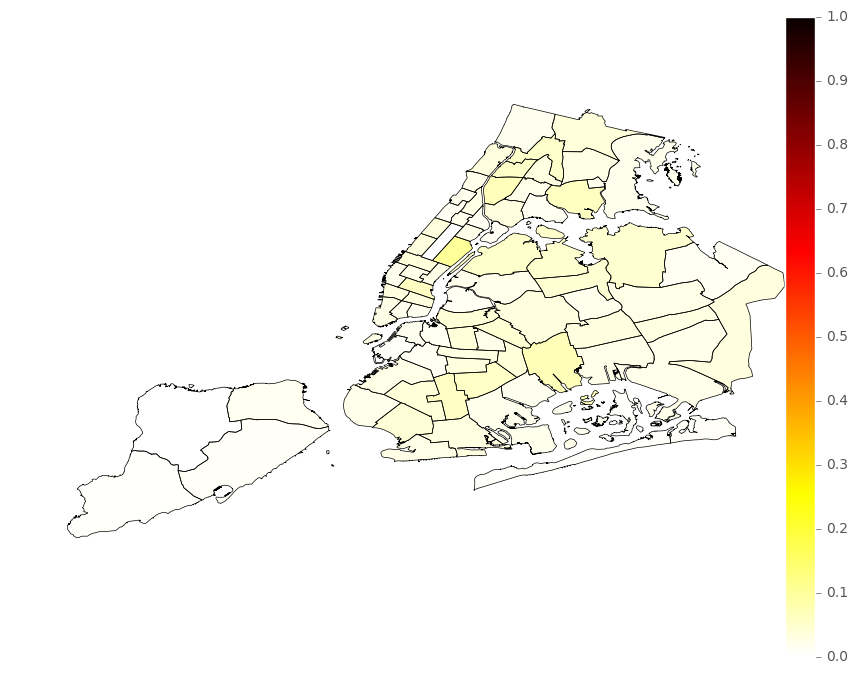

In [1230]:
f, ax = plt.subplots(figsize=(10,8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
precinct.plot(alpha=0.5,linewidth=0.5,ax=ax, column="final_score", colormap="hot_r", vmin=0
              , vmax=5)

# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='hot_r', norm=plt.Normalize(vmin=precinct.final_score.values.min(), vmax=precinct.final_score.values.max()))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax)
ax.set_axis_bgcolor('white') 
plt.show()

In [1127]:
1/77

0.012987012987012988

In [1216]:
breakdown_latlon = pd.DataFrame({"year": range(2005, 2017)})

In [1217]:
for i in precinct.precinct:
    breakdown_latlon["lat_%d" %(i)] = df_2[i].apply(lambda x: x.y).values
    breakdown_latlon["lon_%d" %(i)] = df_2[i].apply(lambda x: x.x).values

In [1218]:
breakdown_latlon

,year,lat_1,lon_1,lat_5,lon_5,lat_6,lon_6,lat_7,lon_7,lat_9,...,lat_115,lon_115,lat_120,lon_120,lat_121,lon_121,lat_122,lon_122,lat_123,lon_123
0,2005,40.714452,-74.008322,40.717616,-73.997021,40.733200,-74.001634,40.716095,-73.984387,40.726985,...,40.755986,-73.878224,40.632618,-74.083233,40.631939,-74.163474,40.579567,-74.106243,40.532503,-74.201851
1,2006,40.715439,-74.007097,40.717966,-73.996645,40.733289,-74.001080,40.716959,-73.985703,40.726617,...,40.755314,-73.877118,40.629050,-74.091128,40.627471,-74.159788,40.575545,-74.110353,40.533571,-74.207907
2,2007,40.715374,-74.007025,40.717872,-73.996528,40.733394,-74.001206,40.716897,-73.985722,40.726594,...,40.755571,-73.877506,40.629262,-74.091117,40.634758,-74.143675,40.576551,-74.109799,40.534709,-74.206193
3,2008,40.715350,-74.006987,40.717623,-73.996558,40.733384,-74.001512,40.716864,-73.985798,40.726473,...,40.755400,-73.876764,40.629959,-74.090108,40.621817,-74.151060,40.575111,-74.111647,40.533641,-74.208038
4,2009,40.715398,-74.006973,40.717869,-73.996554,40.733261,-74.001152,40.716959,-73.985868,40.726759,...,40.755313,-73.876373,40.629001,-74.090857,40.626146,-74.160699,40.576836,-74.110116,40.535457,-74.205004
5,2010,40.716101,-74.006787,40.718066,-73.996389,40.733320,-74.001224,40.717205,-73.985860,40.726819,...,40.755469,-73.876172,40.629916,-74.091536,40.630929,-74.149575,40.576021,-74.110601,40.535663,-74.206107
6,2011,40.715604,-74.006872,40.717852,-73.996516,40.733738,-74.001597,40.717109,-73.985885,40.726681,...,40.755443,-73.876488,40.629089,-74.091202,40.616111,-74.158196,40.574264,-74.113892,40.535517,-74.206274
7,2012,40.716195,-74.007151,40.717684,-73.996519,40.733992,-74.002099,40.716768,-73.985996,40.726725,...,40.756764,-73.877743,40.626384,-74.093329,40.609576,-74.154954,40.578290,-74.110504,40.536875,-74.202323
8,2013,40.715949,-74.007768,40.717747,-73.996406,40.733764,-74.001721,40.717063,-73.985965,40.726650,...,40.756940,-73.877464,40.625744,-74.093740,40.611090,-74.153911,40.578337,-74.111546,40.537587,-74.200253
9,2014,40.715573,-74.007949,40.718030,-73.996560,40.733882,-74.001839,40.716920,-73.986007,40.726518,...,40.756441,-73.877555,40.625661,-74.094743,40.612354,-74.154104,40.578188,-74.111373,40.537536,-74.201393


In [1219]:
breakdown_latlon.to_csv("year_points.csv")

In [1173]:
breakdown_latlon.to_csv("historical_points.csv")

In [1157]:
precinct.to_csv("two_info.csv")